In [1]:
import scanpy as sc
import scFates as scf
import numpy as np
adata=sc.read("data/adata_glia_raw.h5ad")
sc.set_figure_params(figsize=(9,3))

import scrublet as scr
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs["doublet_scores"]=doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 33.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.4%
Elapsed time: 22.7 seconds


Finding overdispersed features
    computing mean and variances
    gam fitting
    found 6343 over-dispersed features (0:00:02) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



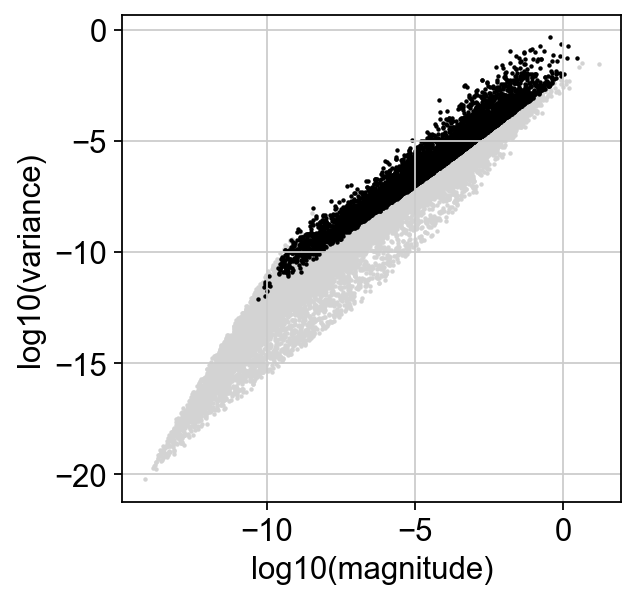

In [2]:
sc.set_figure_params()
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e3)
sc.pp.log1p(adata)
scf.pp.find_overdispersed(adata,plot=True)

In [3]:
adata.layers["scaled"]=sc.pp.scale(adata.X,max_value=10,copy=True)
adata.obsm["X_pca"]=sc.pp.pca(adata[:,adata.var.highly_variable].layers["scaled"])

In [4]:
sc.pp.neighbors(adata,metric="cosine",n_pcs=30)

In [5]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

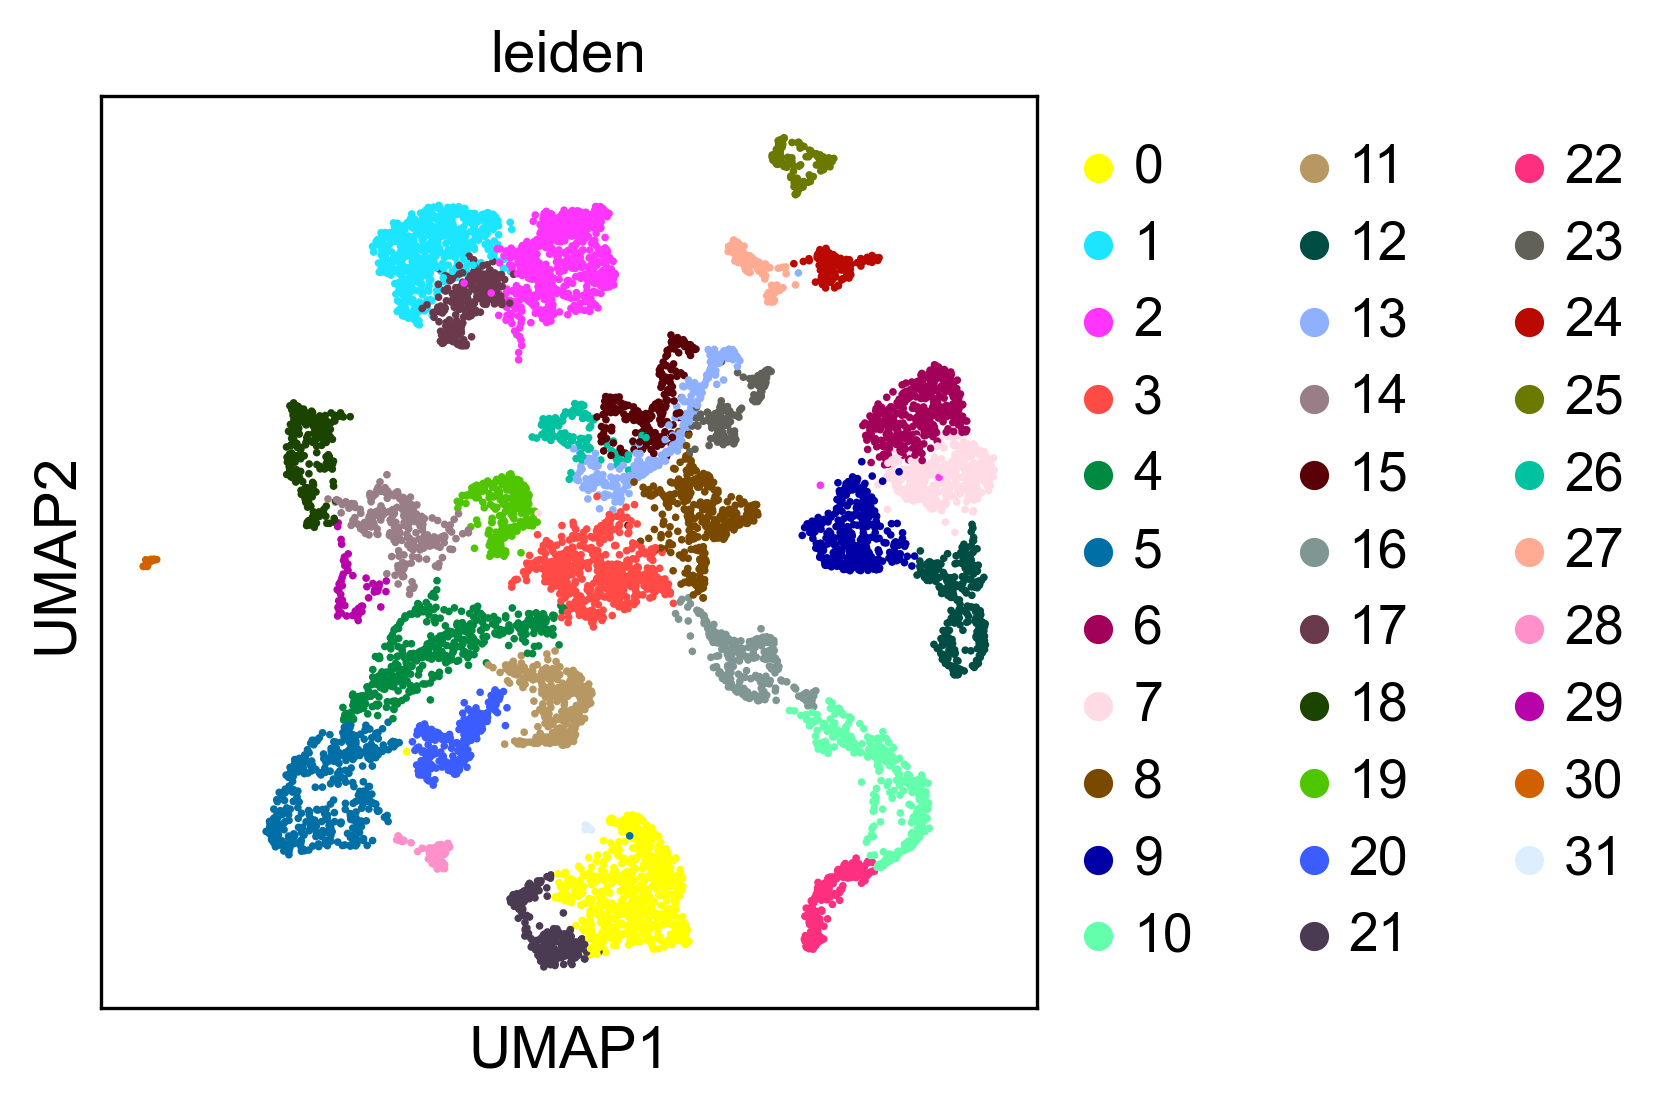

In [6]:
sc.set_figure_params(dpi=150)
sc.pl.umap(adata,color=["leiden"])

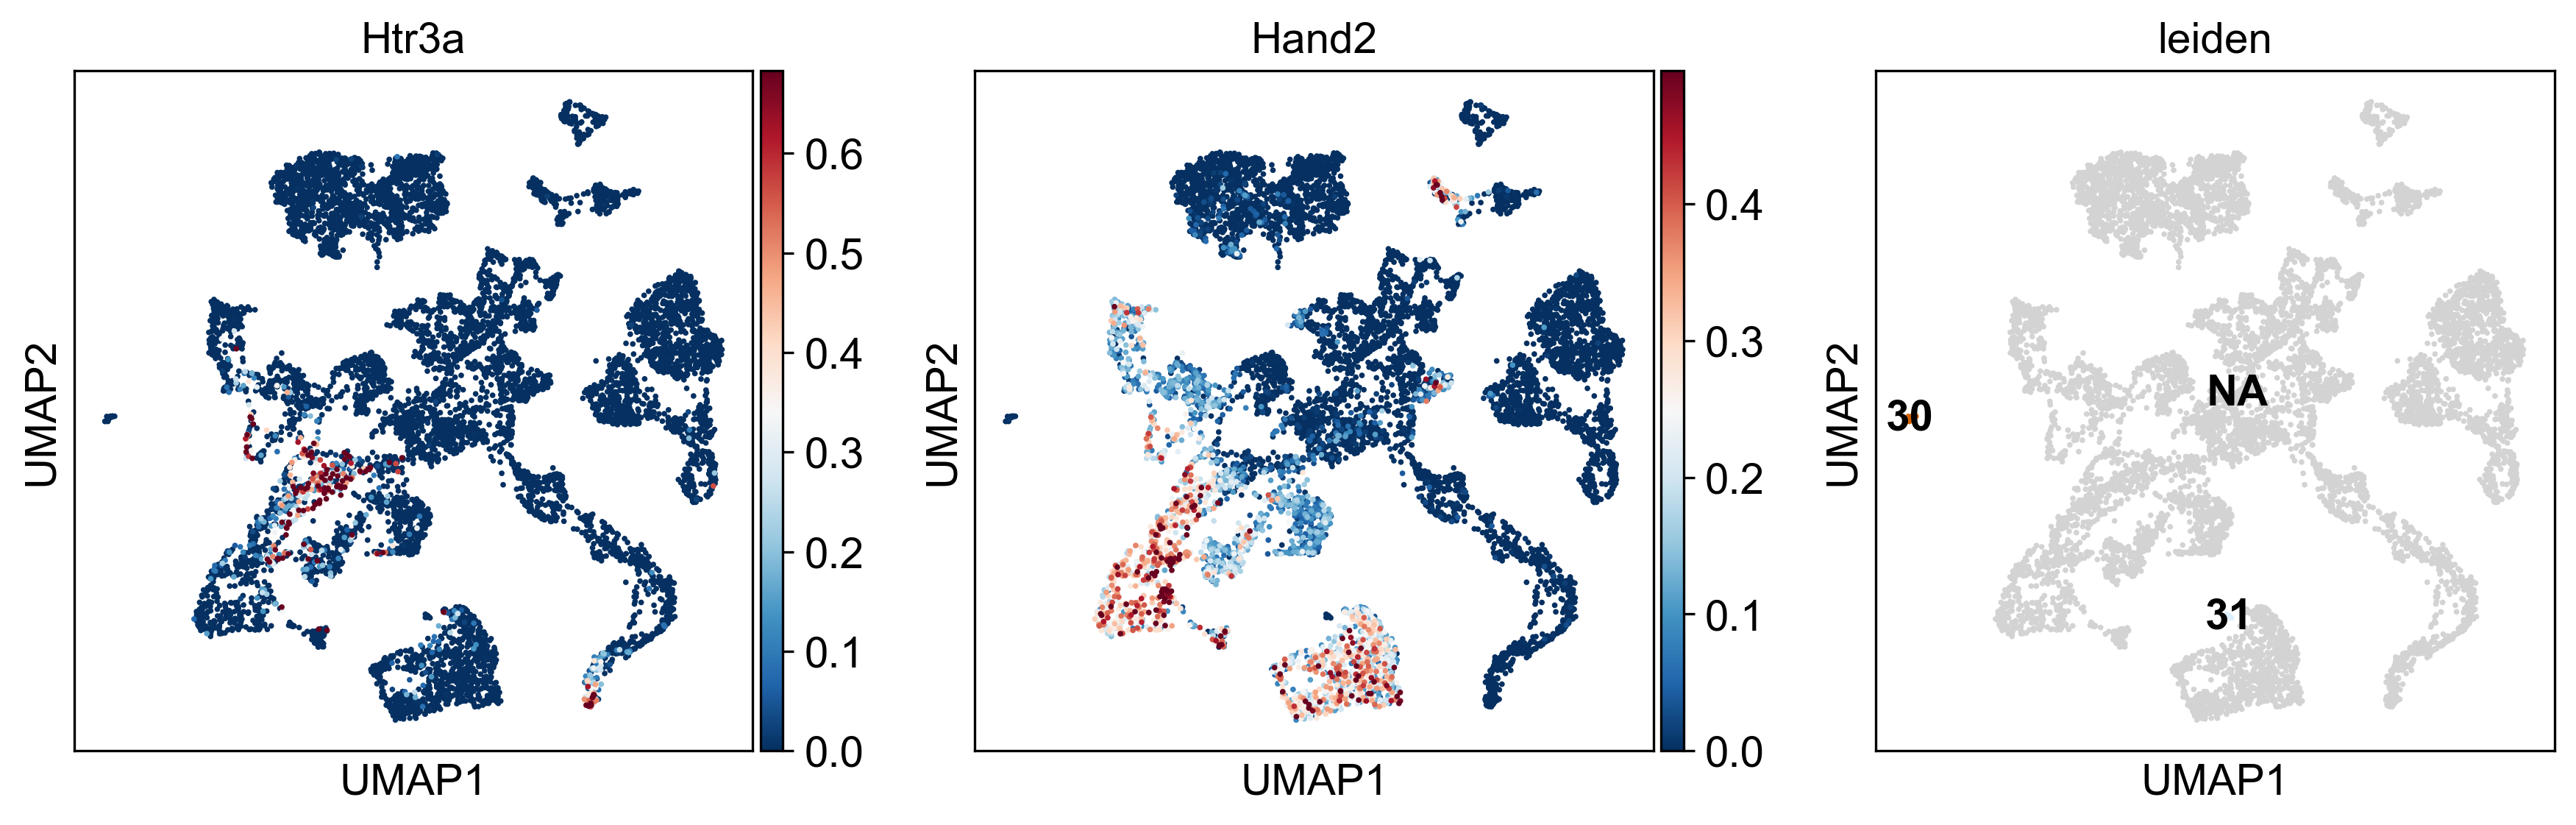

In [7]:
sc.pl.umap(adata,color=["Htr3a","Hand2","leiden"],legend_loc="on data",groups=["30","31"],cmap="RdBu_r",vmax="p99")

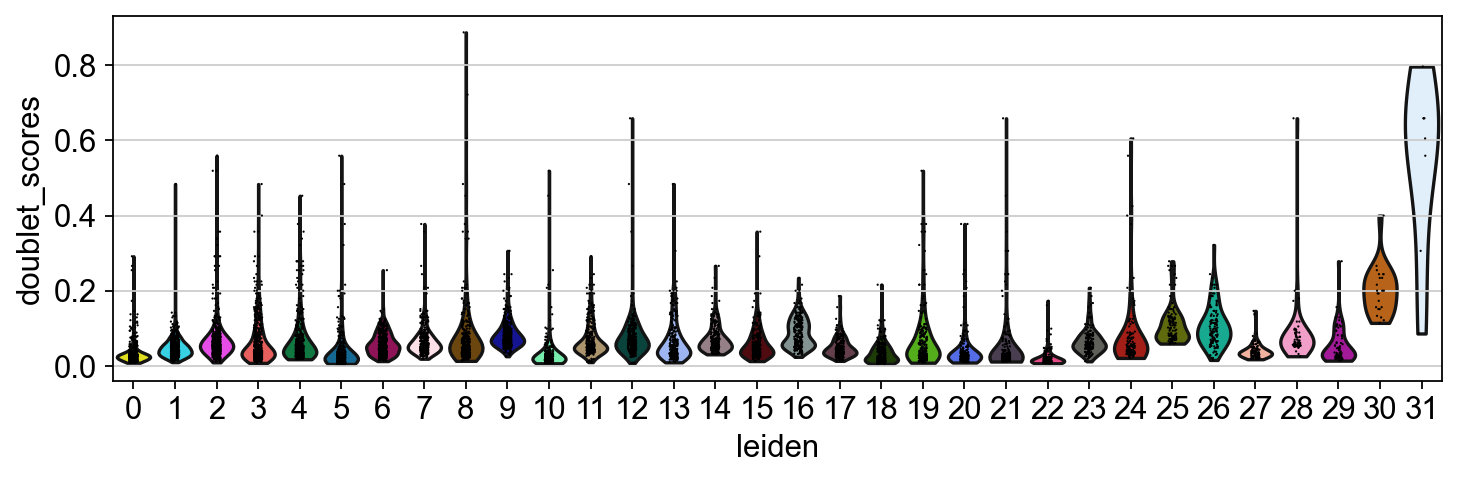

In [8]:
sc.set_figure_params(figsize=(9,3))
sc.pl.violin(adata,"doublet_scores","leiden")

In [9]:
adata.write("data/adata_glia_prefilter.h5ad")

Trying to set attribute `.var` of view, copying.


Finding overdispersed features
    computing mean and variances
    gam fitting
    found 6366 over-dispersed features (0:00:02) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



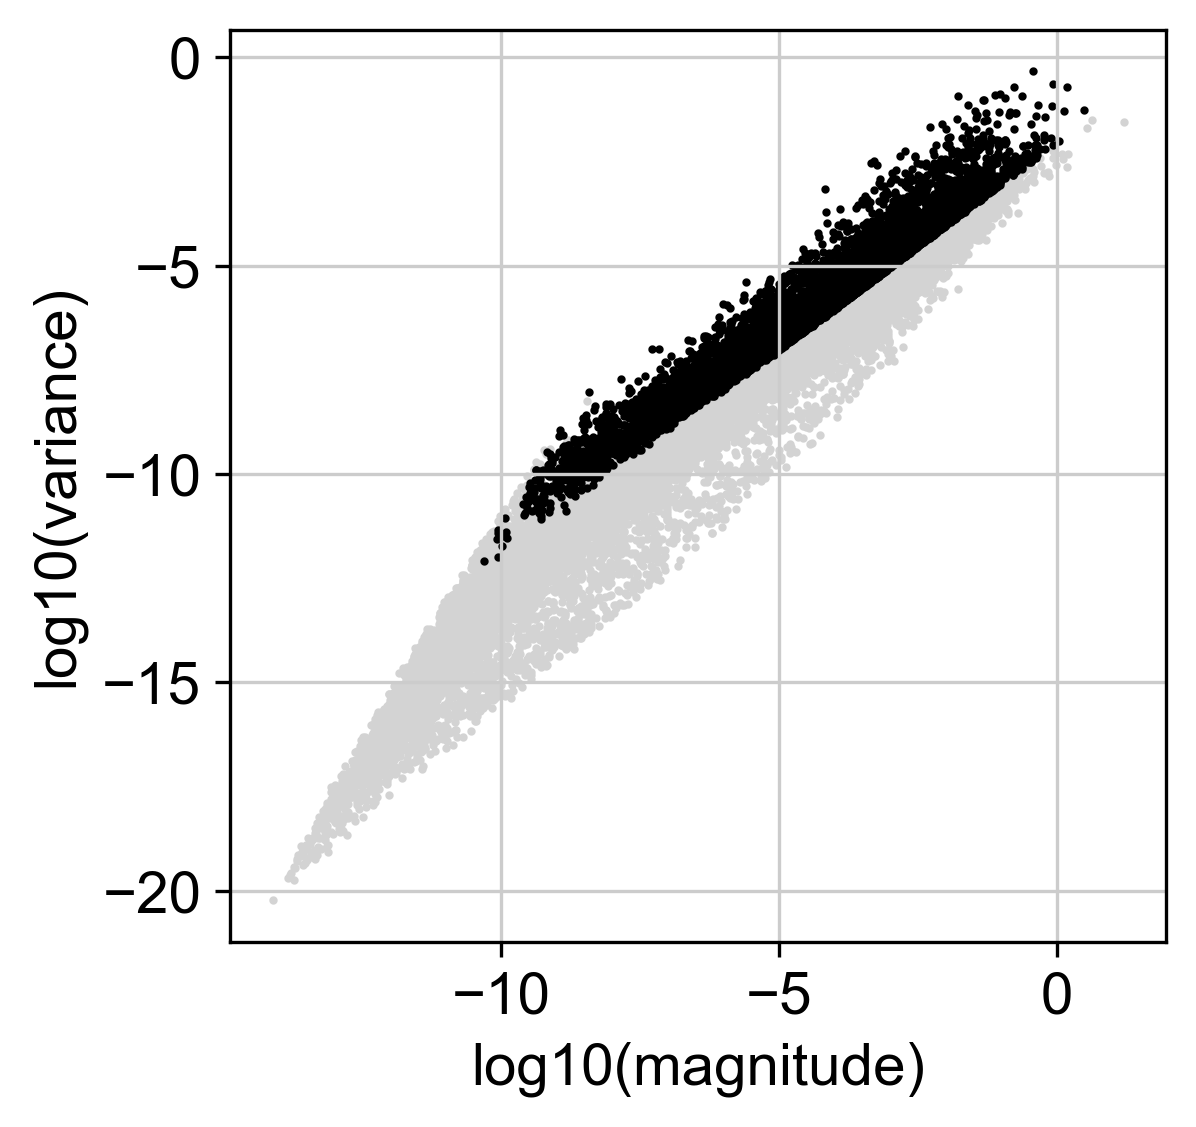

In [9]:
sc.set_figure_params(dpi=150)
adata=adata[~adata.obs.leiden.isin(["30","31"])]
sc.pp.filter_genes(adata,min_cells=3)
scf.pp.find_overdispersed(adata,plot=True)
adata.layers["scaled"]=sc.pp.scale(adata.X,max_value=10,copy=True)
adata.obsm["X_pca"]=sc.pp.pca(adata[:,adata.var.highly_variable].layers["scaled"])
sc.pp.neighbors(adata,metric="cosine",n_pcs=30)

In [10]:
import pandas as pd
import palantir
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(adata.obsm["X_pca"][:,:50],index=adata.obs_names),knn=80)
#ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=10)
adata.obsm["X_diff"]=dm_res["EigenVectors"].iloc[:,1:9].values

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


Determing nearest neighbor graph...


In [11]:
sc.pp.neighbors(adata,n_neighbors=40,use_rep="X_diff",method="rapids")

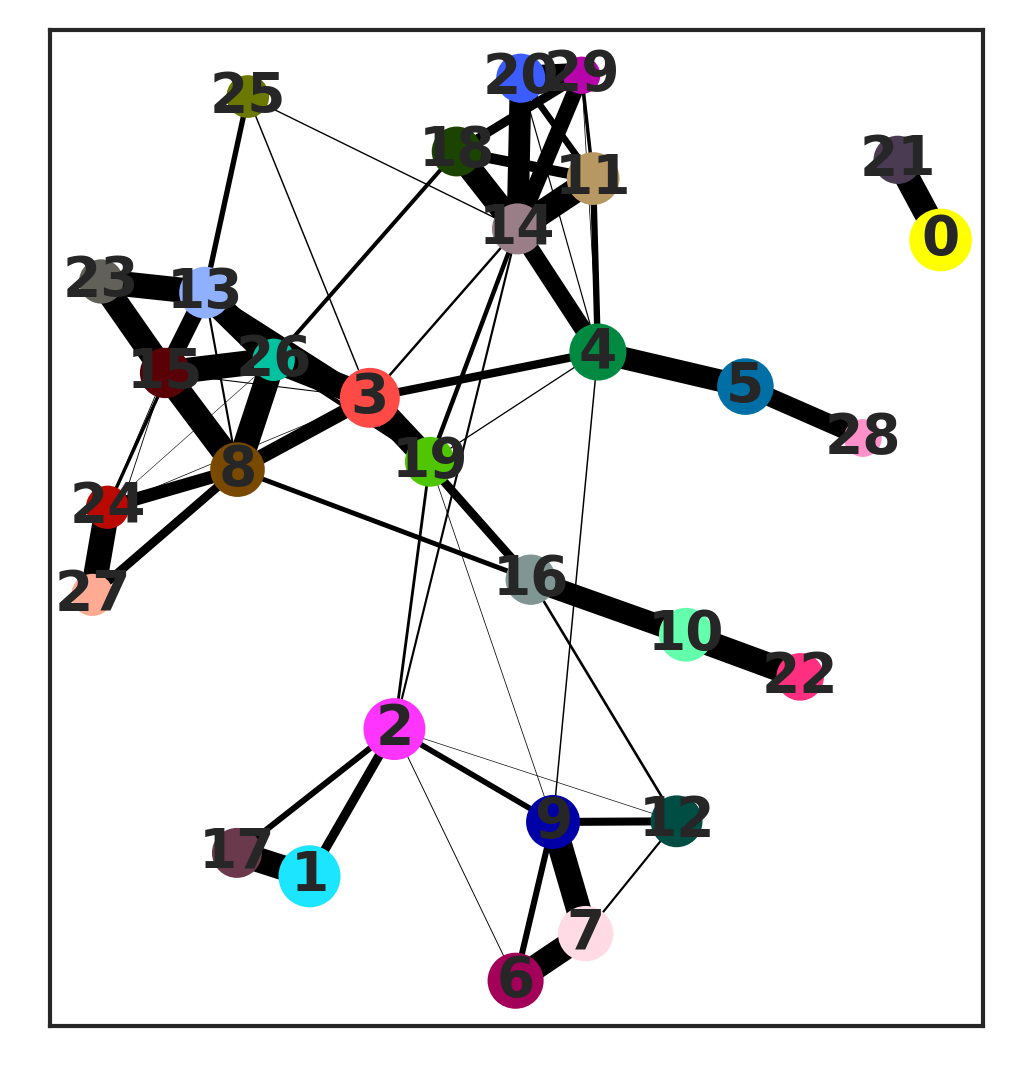

In [16]:
sc.tl.paga(adata,"leiden")
sc.pl.paga(adata,threshold=.02)

In [20]:
sc.pp.neighbors(adata,n_neighbors=80,use_rep="X_diff",method="rapids")

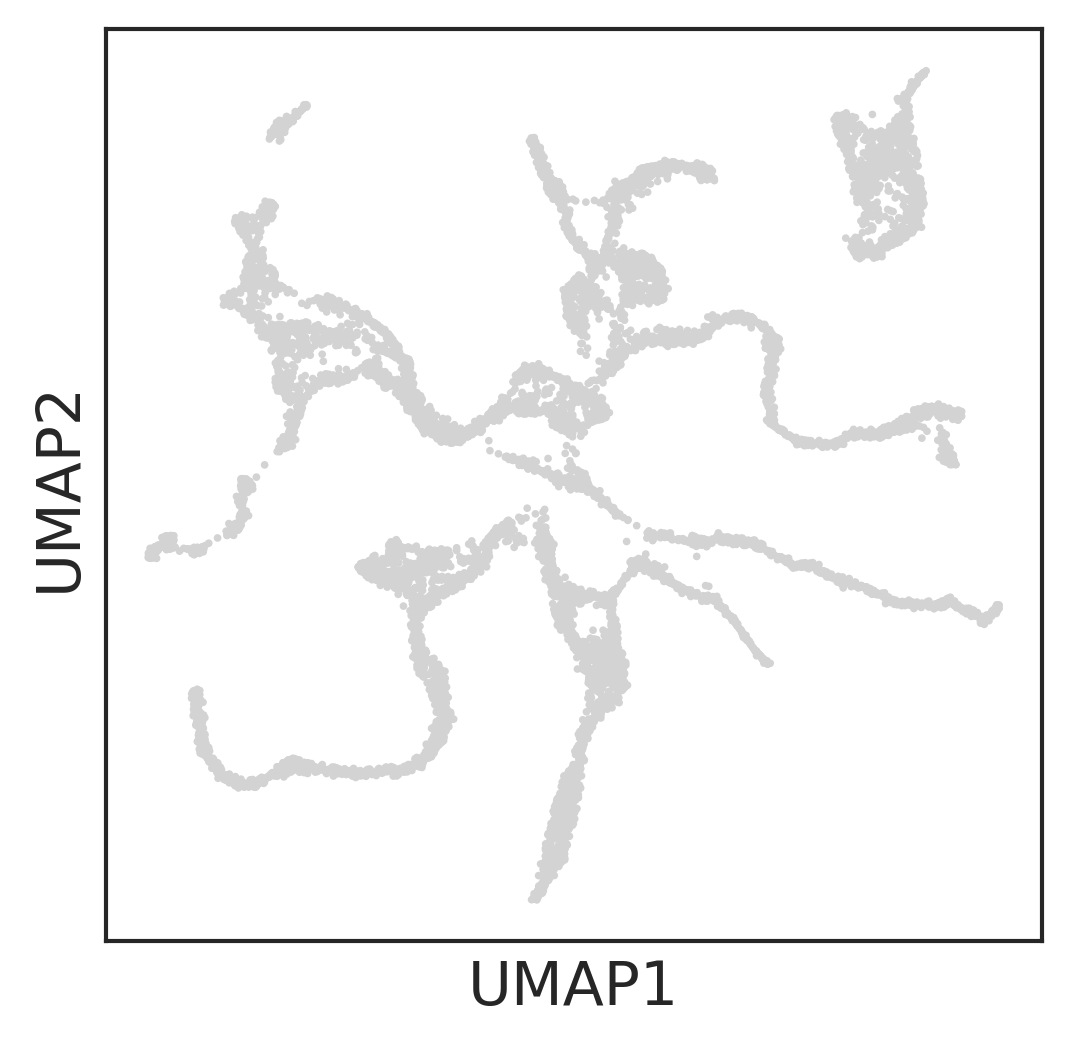

In [29]:
sc.tl.umap(adata,spread=.6,init_pos="paga")
sc.pl.umap(adata)

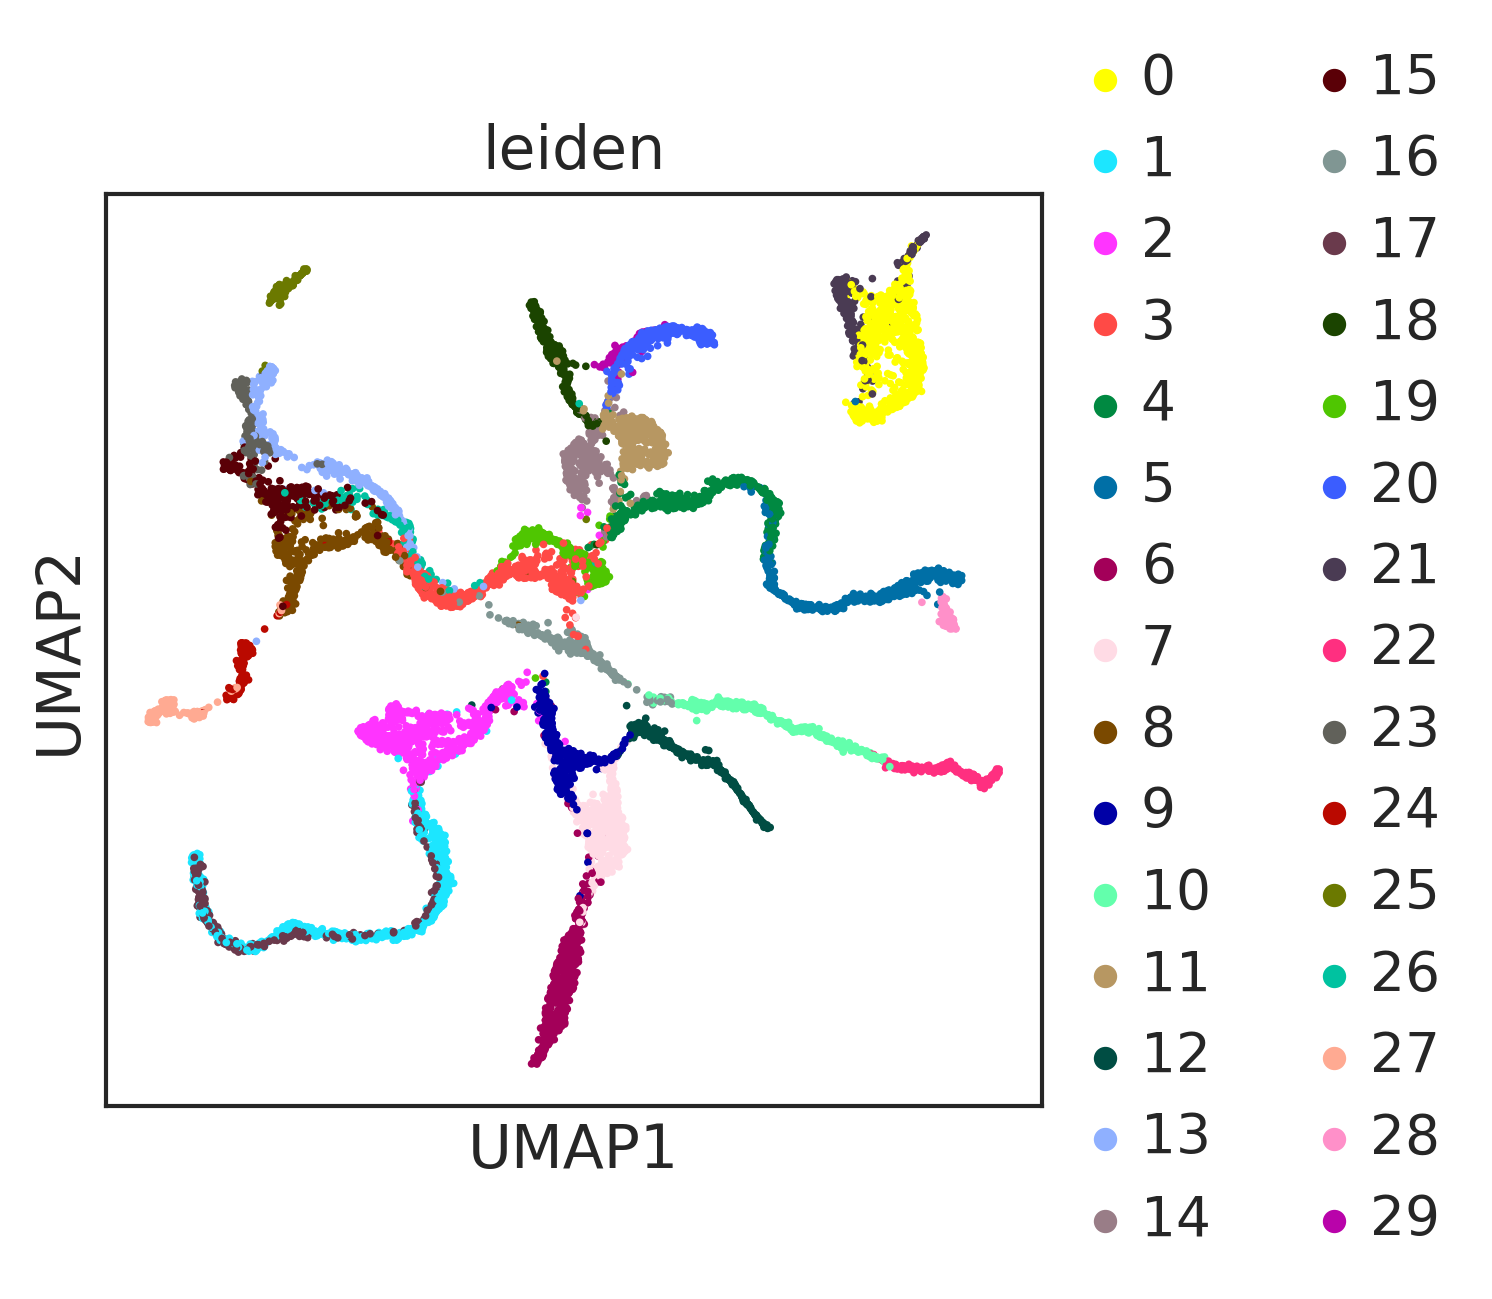

In [30]:
sc.pl.umap(adata,color="leiden")

In [31]:
from scipy.sparse import csr_matrix
adata.X=csr_matrix(np.e**adata.X.A-1)
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

In [32]:
imp_df = palantir.utils.run_magic_imputation(pd.DataFrame(adata.X.A, index=adata.obs_names, columns=adata.var_names), dm_res)
adata.layers["palantir_imp"]=csr_matrix(imp_df.values)

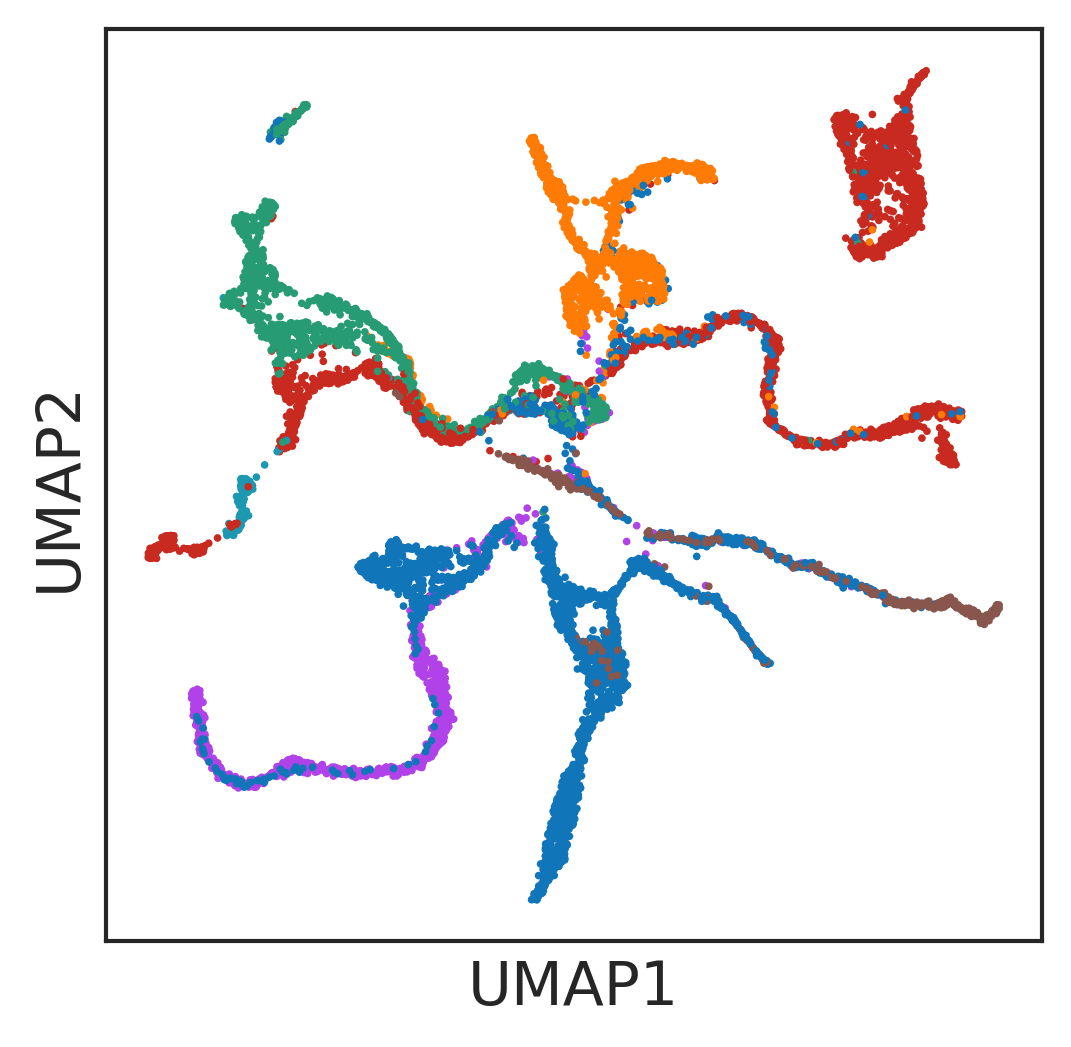

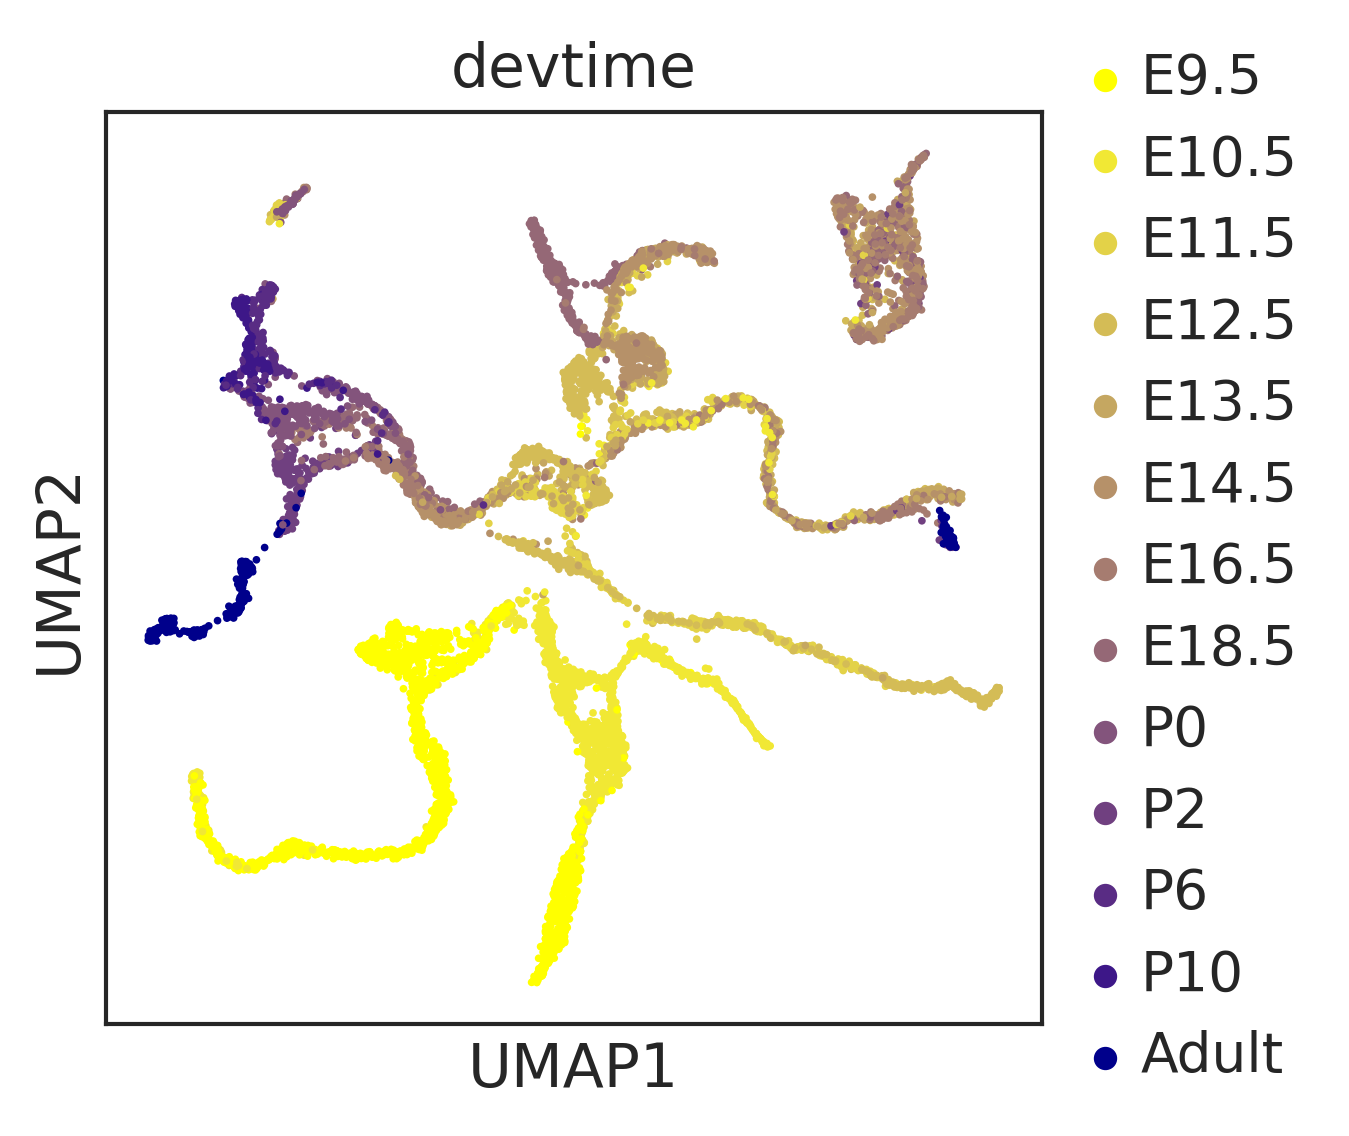

In [33]:
sc.pl.umap(adata,color="location",
           palette=["#B141E8","#88564C","#FE7B06","#1C99B1","#279B74","#C92A20","#1176B9"],
           legend_loc="none",title="")
adata.obs.devtime=adata.obs.devtime.cat.reorder_categories(['E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5', 'E14.5', 'E16.5',
       'E18.5', 'P0', 'P2', 'P6', 'P10',"Adult"])
dev_pal=["#FFFF00","#F1E834","#E3D248","#D4BC56","#C5A761","#B69169","#A67C70","#956876","#83547C","#704080","#592C84","#3D1788","#00008B"]
sc.pl.umap(adata,color="devtime",palette=dev_pal)

In [35]:
import rpy2
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [36]:
%%R -i adata -o ct
source("CytoTRACE.R")
rownames(adata@assays@data$X)=rownames(adata)
colnames(adata@assays@data$X)=colnames(adata)
results=CytoTRACE(adata@assays@data$X,ncores=11)
ct=results$CytoTRACE

In [37]:
adata.obs["CytoTRACE"]=ct

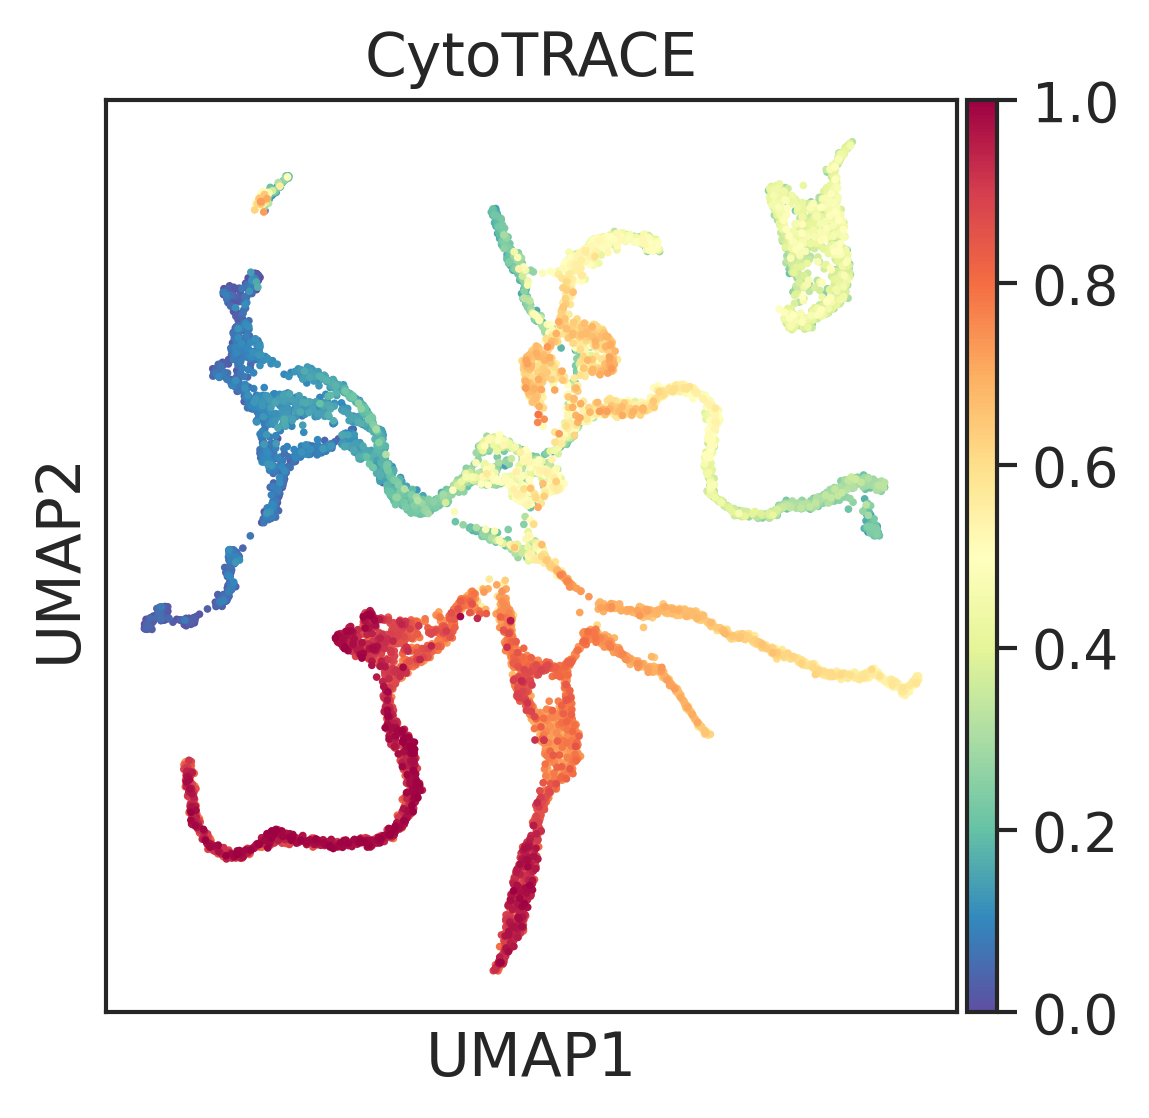

In [38]:
sc.pl.umap(adata,color="CytoTRACE",cmap="Spectral_r")

In [39]:
adata.write("data/adata_processed.h5ad")